# Probablistic model building genetic algorithm

In [1]:
%cd /mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

from src.kinetic_model import KineticModel, modelSpace_to_modelParams
from src.neural_network_builder import KineticNeuralNetworkBuilder
from src.model_spaces import get_cas9_uniform_ms, get_cas9_finkelstein_ms
from src.data import load_finkelstein_data as get_data
# reload from previous trained (already at full convergence/early stopped)
from src.reload import reload_from_dir
%matplotlib inline

Using TensorFlow backend.


detected tf2 - using compatibility mode


In [3]:
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import shutil
import os
import pickle
import gc
from sklearn.model_selection import train_test_split

## Load data

In [4]:
wd = "outputs/final/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep3-gRNA1"
#wd = "outputs/final/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep5-gRNA2"

target = "wtCas9_cleave_rate_log"

res = get_data(target=target, logbase=10, make_switch=wd.endswith("gRNA2"))
# unpack data tuple
(x_train, y_train), (x_test, y_test) = res

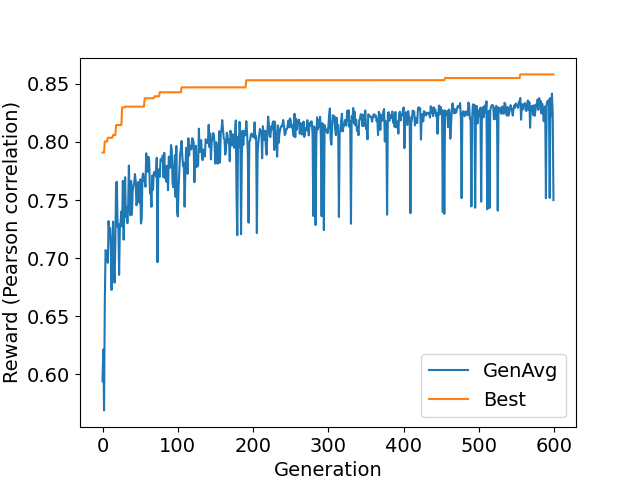

In [5]:
from IPython.display import Image

Image(filename=os.path.join(wd, "reward_vs_time.png"), width=400)

## Vis Search Stats

['outputs/final/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep3-gRNA1/RANGE_D.png', 'outputs/final/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep3-gRNA1/RANGE_ST.png', 'outputs/final/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep3-gRNA1/filters.png', 'outputs/final/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep3-gRNA1/hidden_size.png', 'outputs/final/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep3-gRNA1/kernel_size.png', 'outputs/final/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep3-gRNA1/reshape_fn.png']


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


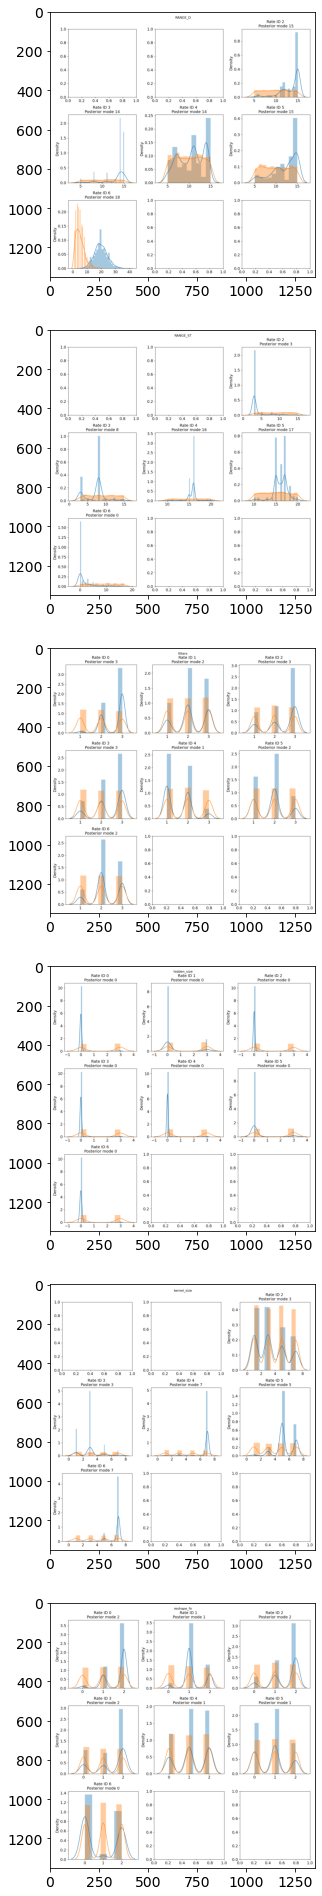

In [6]:
import matplotlib.image as mpimg

plt.figure(figsize=(40,40))
columns = 1
excl = ['reward_vs_time.png', 'test_pred.png', 'model.png']
images = [os.path.join(wd,x) for x in sorted([x for x in os.listdir(wd) \
                                                            if not x.startswith(".") and x.endswith("png") and not x in excl])]
print(images)
images = [mpimg.imread(_) for _ in images]
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)

## Reload Model

In [7]:
kinn_model_space = get_cas9_finkelstein_ms()
print(kinn_model_space)

StateSpace with 7 layers and 1 total combinations


In [8]:
# manager configs
manager_kwargs={
    'output_op': 
        lambda: tf.keras.layers.Lambda(lambda x: tf.math.log(tf.clip_by_value(x, 10**-5, 10**-1))/np.log(10), name="output_log10"),  # change the clip as well
    'n_feats': 25,  # remember to change this!!
    'n_channels': 9,
}
mb = reload_from_dir(wd, manager_kwargs, model_fn=KineticNeuralNetworkBuilder)
model = mb.model

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


spearman SpearmanrResult(correlation=0.8000933568123527, pvalue=0.0)
pearson (0.8581137281665965, 0.0)


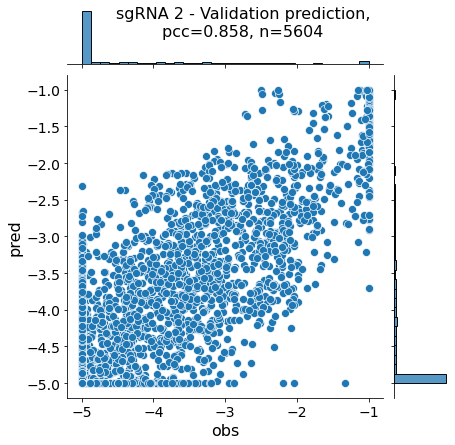

In [9]:
x_train_b = mb.blockify_seq_ohe(x_train)
x_test_b = mb.blockify_seq_ohe(x_test)

y_hat = model.predict(x_test_b).flatten()
test_pcc_old = ss.pearsonr(y_hat, y_test)[0]

h = sns.jointplot(y_test, y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_test))
p_old = ss.pearsonr(y_hat, y_test)
print("pearson", p_old)
h.fig.suptitle("sgRNA 2 - Validation prediction,\npcc=%.3f, n=%i"%(test_pcc_old, len(y_hat)), fontsize=16)
plt.show()


spearman SpearmanrResult(correlation=0.8456765990336281, pvalue=0.0)
pearson 0.9247384129085515


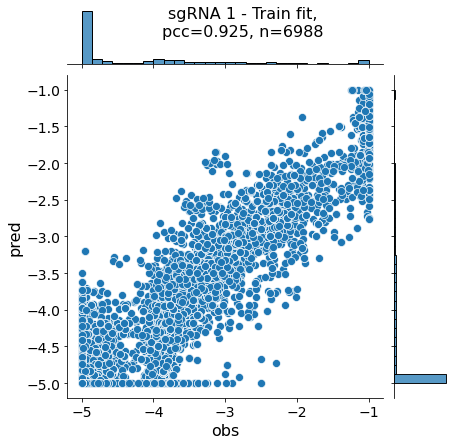

In [10]:
y_hat = model.predict(x_train_b).flatten()
test_pcc_old = ss.pearsonr(y_hat, y_train)[0]

h = sns.jointplot(y_train, y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_train))
print("pearson", test_pcc_old)
h.fig.suptitle("sgRNA 1 - Train fit,\npcc=%.3f, n=%i"%(test_pcc_old, len(y_hat)), fontsize=16)
plt.show()


## Retrain and Check for Improvements
Don't run, just overfitting

checkpointer = ModelCheckpoint(
    filepath=os.path.join(wd,"bestmodel_retrain.h5"), mode='min', verbose=0, save_best_only=True,
    save_weights_only=True)
earlystopper = EarlyStopping(
    monitor="val_loss",
    mode='min',
    patience=15,
    verbose=0)

hist = model.fit(x_train_b, y_train,
          batch_size=32,
          validation_data=(x_test_b, y_test),
          callbacks=[checkpointer, earlystopper],
          epochs=500, verbose=0)
model.load_weights(os.path.join(wd,"bestmodel_retrain.h5"))


plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

y_hat = model.predict(x_test_b).flatten()
y_hat = np.clip(y_hat, -5, -1)
h = sns.jointplot(y_test, y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_test))
p = ss.pearsonr(y_hat, y_test)
print("pearson", p)
h.fig.suptitle("Testing prediction, pcc=%.3f"%p[0], fontsize=16)

if p_old[0] >= p[0]:
    model.load_weights(os.path.join(wd, "AmberSearchBestModel.h5"))
    print("retraining is overfitting; load from amber search")
else:
    print("retraining improves the model")

# Getting Kinetic Rates from the Model

In [11]:
[str(x.__dict__) for x in mb.kinn.rates]

["{'name': 'k_01', 'state_list': ['0', '1'], 'input_range': [0, 3], 'kernel_size': 3, 'scatter_nd': [((0, 0), -1), ((1, 0), 1)], 'filters': 2, 'SOURCE': '0', 'TARGET': '1', 'padding': 'valid', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3, 'hidden_size': 0, 'reshape_fn': 2, 'template': None}",
 "{'name': 'k_10', 'state_list': ['1', '0'], 'input_range': [0, 3], 'kernel_size': 3, 'scatter_nd': [((1, 1), -1), ((0, 1), 1)], 'filters': 3, 'SOURCE': '1', 'TARGET': '0', 'padding': 'valid', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3, 'hidden_size': 0, 'reshape_fn': 1, 'template': None}",
 "{'name': 'k_12', 'state_list': ['1', '2'], 'input_range': [5, 20], 'kernel_size': 7, 'scatter_nd': [((1, 1), -1), ((2, 1), 1)], 'filters': 3, 'SOURCE': '1', 'TARGET': '2', 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 5, 'RANGE_D': 15, 'hidden_size': 0, 'reshape_fn': 2, 'template': None}",
 "{'name': 'k_21', 'state_list': ['2', '1'], 'input_range': [8, 22], 'kernel_size': 7, 'scatter_nd': [((2, 2), -1), ((1, 2), 1)], 'filt

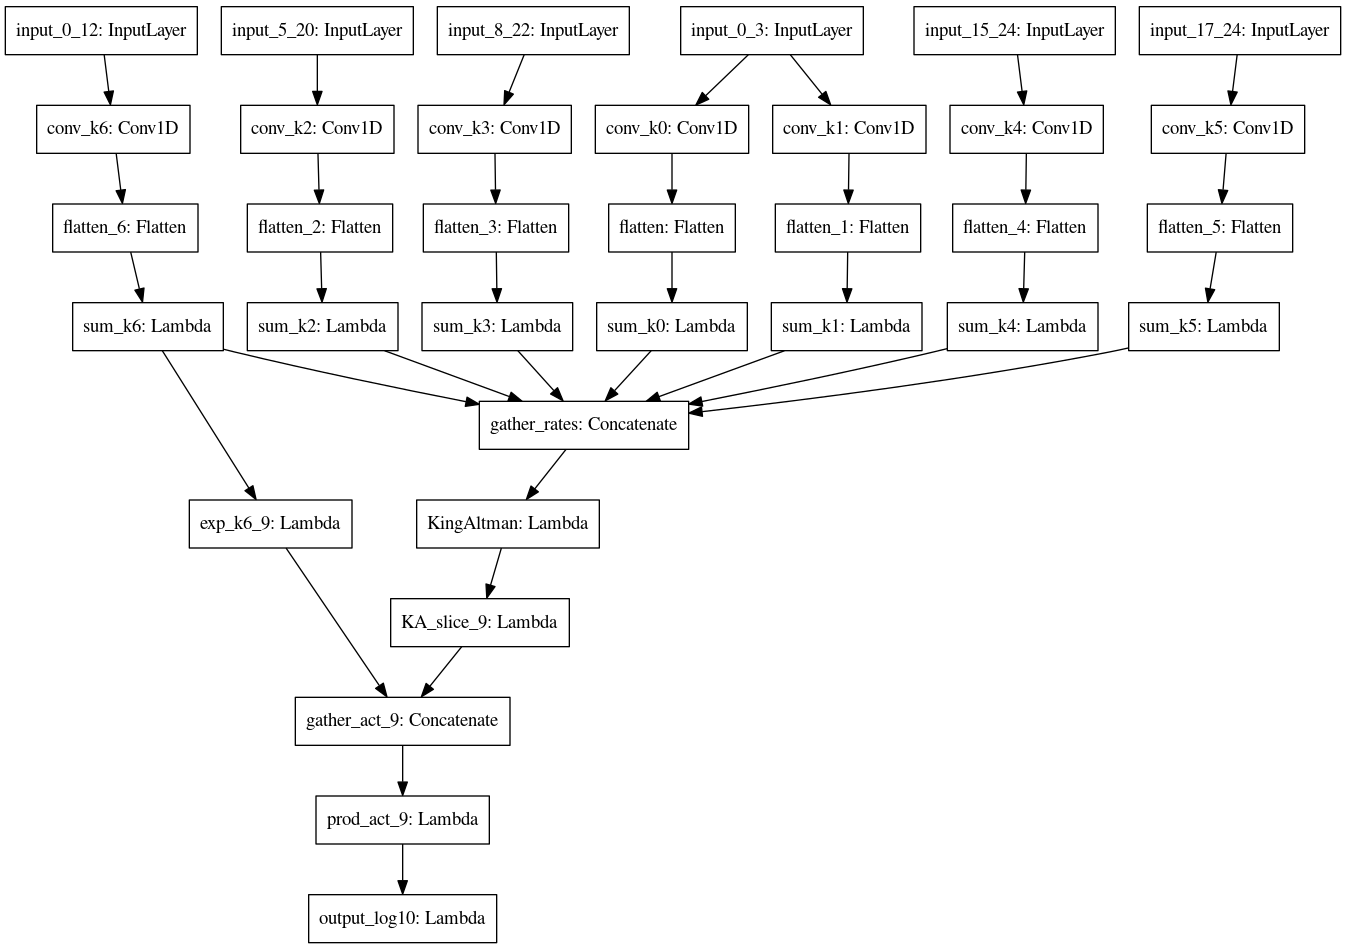

In [12]:
tf.keras.utils.plot_model(model)

In [13]:
layer_dict = {l.name:l for l in model.layers}

In [14]:
# confirmed - is aligned from rate 0 to rate N
rate_mod = tf.keras.models.Model(inputs=model.inputs, outputs=layer_dict['gather_rates'].output) 
#rate_mod = tf.keras.models.Model(inputs=model.inputs, outputs=
#                                 [layer_dict["conv_k%i"%k].output for k in range(7)])

In [15]:
outs = rate_mod.predict([x_test_b[i] for i in range(len(x_test_b))])
outs.squeeze()

array([[ -0.83592784,   1.5456536 ,  -0.7192035 , ...,   0.7071696 ,
         -0.3970016 ,   0.23986071],
       [ -0.83592784,   1.5456536 ,   0.3558121 , ...,   0.7071696 ,
         -0.3970016 ,  -8.672298  ],
       [ -0.83592784,   1.5456536 ,   0.17513801, ...,   0.5608655 ,
         -0.9891662 ,   0.23986071],
       ...,
       [ -2.427826  ,   4.0668125 ,   0.35522836, ...,   0.7071696 ,
         -0.3970016 , -10.527864  ],
       [  0.09509152,   0.3180307 ,   2.499037  , ...,  -1.2078242 ,
         -0.3970016 ,  -1.7859741 ],
       [ -0.83592784,   1.5456536 ,  -3.958697  , ...,  -1.2113433 ,
         -0.3970016 ,  -3.6646814 ]], dtype=float32)

In [16]:
outs = pd.DataFrame(outs, columns=['k_%i'%i for i in range(outs.shape[1])])
outs['obs_cleavage_log10'] = y_test
outs['pred_cleavage_log10'] = model.predict(x_test_b).flatten()

In [17]:
outs.tail(10).round(3)

,k_0,k_1,k_2,k_3,k_4,k_5,k_6,obs_cleavage_log10,pred_cleavage_log10
5594,-0.836,1.546,-0.537,2.590,0.608,-1.686,-3.373,-4.176,-2.998
5595,-0.836,1.546,0.525,7.189,1.247,-2.058,-6.603,-5.000,-5.000
5596,-0.836,1.546,3.624,6.204,2.722,-0.464,0.240,-1.020,-1.275
5597,-0.836,1.546,-1.553,5.963,0.066,-2.209,-2.743,-3.719,-4.742
5598,-0.836,1.546,-0.538,7.040,1.532,-2.166,-6.603,-5.000,-5.000
5599,-0.836,1.546,-1.759,5.648,0.707,-0.397,-6.586,-5.000,-5.000
5600,-0.836,1.546,0.904,2.704,0.606,-0.252,-4.576,-4.246,-3.495
5601,-2.428,4.067,0.355,2.704,0.707,-0.397,-10.528,-5.000,-5.000
5602,0.095,0.318,2.499,4.428,-1.208,-0.397,-1.786,-1.000,-2.452
5603,-0.836,1.546,-3.959,5.770,-1.211,-0.397,-3.665,-5.000,-5.000


In [18]:
outs.to_csv(os.path.join(wd, "rates_df.tsv"), sep="\t", index=False)

In [19]:
matched = np.zeros((1,25,9))

rates = rate_mod.predict(mb.blockify_seq_ohe(matched)).flatten()
print("kinn rate for matched\n")
for i in range(7):
    r = rates[i]
    print("k_%i"%i, r)


kinn rate for matched

k_0 -0.83592784
k_1 1.5456536
k_2 3.3663657
k_3 2.7041843
k_4 0.7071696
k_5 -0.3970016
k_6 0.23986071


<AxesSubplot:title={'center':'Reverse'}>

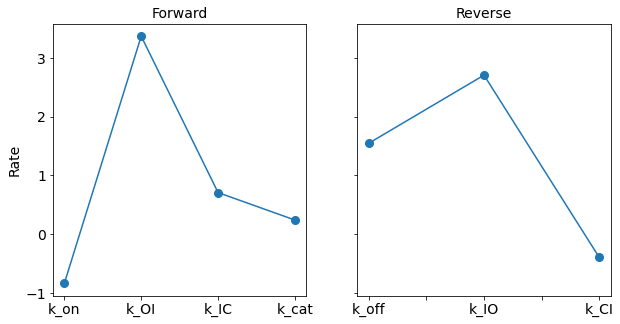

In [20]:
rate_names = ['k_on', 'k_off', 'k_OI', 'k_IO', 'k_IC', 'k_CI', 'k_cat']
rate_df = pd.DataFrame({'rate': rates}, index=rate_names)
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=True)
rate_df.loc[['k_on', 'k_OI', 'k_IC', 'k_cat']].plot(ax=axs[0], legend=False, style='-o', title="Forward", 
                                                    ylabel="Rate")
rate_df.loc[['k_off', 'k_IO', 'k_CI']].plot(ax=axs[1], legend=False, style='-o', title="Reverse")
#axs[0].set_ylim(0,7)

# make predictions on better annotated dataframes

In [21]:
from src.crispr_kinn_predict import get_letter_index, featurize_alignment, make_alignment

In [22]:
df1 = pd.read_csv("./data/sgRNA_1.csv")
df2 = pd.read_csv("./data/sgRNA_2.csv")
df1 = df1.dropna()
df2 = df2.dropna()
cl_cols = ['wtCas9_cleave_rate_log',]
# fix the missing log10 in raw data
df1[cl_cols] = np.log10(df1[cl_cols])

# clip at limit of detection
LOD = 1e-5
df1[cl_cols] = np.maximum(df1[cl_cols], np.log10(LOD))
df2[cl_cols] = np.maximum(df2[cl_cols], np.log10(LOD))
LOD = 1e-1
df1[cl_cols] = np.minimum(df1[cl_cols], np.log10(LOD))
df2[cl_cols] = np.minimum(df2[cl_cols], np.log10(LOD))

In [23]:
# step 1, alignment
assert df1.iloc[0]['descriptor'] == 'Matched'
alns1 = [make_alignment(ref=df1.iloc[0]['sequence'], alt=row['sequence']) for _, row in df1.iterrows()]
assert df2.iloc[0]['descriptor'] == 'Matched'
alns2 = [make_alignment(ref=df2.iloc[0]['sequence'], alt=row['sequence']) for _, row in df2.iterrows()]
# step 2, featurize
ltidx = get_letter_index()
mats1 = featurize_alignment(alns1, ltidx)
mats2 = featurize_alignment(alns2, ltidx)

In [24]:
def make_predictions(mats):
    mats_bl = mb.blockify_seq_ohe(mats)
    preds = mb.model.predict(mats_bl)
    int_rates = rate_mod.predict(mats_bl)
    pred_rates = pd.DataFrame(np.hstack([preds, int_rates]), columns=['pred_cleave_rate_log10'] + rate_names)
    return pred_rates

In [25]:
cols_to_keep = ['sequence', 'descriptor', 'wtCas9_ndABA', 'wtCas9_ndABA_unc', 
                'wtCas9_cleave_rate_log', 'wtCas9_cleave_rate_log_unc']
p1 = make_predictions(mats1)
# need to reset_index to compensate for dropna
df1_pred = pd.concat([df1[cols_to_keep].reset_index(), p1], axis=1).drop(columns='index')
p2 = make_predictions(mats2)
df2_pred = pd.concat([df2[cols_to_keep].reset_index(), p2], axis=1).drop(columns='index')

In [26]:
# write out
print(wd)
df1_pred.to_csv(os.path.join(wd, "AnnotatedRatesDf-sgRNA1.tsv"), sep="\t", index=False)
df2_pred.to_csv(os.path.join(wd, "AnnotatedRatesDf-sgRNA2.tsv"), sep="\t", index=False)

outputs/final/KINN-wtCas9_cleave_rate_log-finkelstein-0-rep3-gRNA1


# Other performance measurement

spearman SpearmanrResult(correlation=0.8047831028567158, pvalue=3.231e-319)
pearson (0.8489156369147017, 0.0)


Text(0.5, 0.98, 'Held-out Test prediction,\npcc=0.849, n=1401')

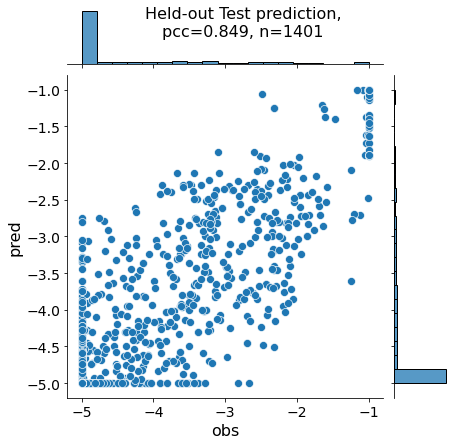

In [28]:
x_ext, y_ext = get_data(target=target, logbase=10, make_switch=wd.endswith("gRNA2"), return_remainder=True)
x_ext_b = mb.blockify_seq_ohe(x_ext)
y_ext_hat = model.predict(x_ext_b).flatten()

h = sns.jointplot(y_ext, y_ext_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_ext_hat, y_ext))
p = ss.pearsonr(y_ext_hat, y_ext)
print("pearson", p)
h.fig.suptitle("Held-out Test prediction,\npcc=%.3f, n=%i"%(p[0], len(x_ext)), fontsize=16)